### **Laboratorio 6**

- Juan Pablo Solis
- Isabella Miralles

In [18]:
import json
import re
import string
import pandas as pd
import nltk

# Descargar stopwords en español (solo la primera vez)
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("spanish"))

def limpiar_texto(texto):
    texto = texto.lower()
    
    texto = re.sub(r"[@#']", "", texto)
    
    texto = re.sub(r"http\S+|www.\S+", "", texto)
    
    texto = re.sub(r"[^\w\sáéíóúüñ]", "", texto)
    
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    
    texto = re.sub(r"\d+", "", texto)
    
    texto = " ".join([w for w in texto.split() if w not in stop_words])
    
    return texto.strip()

def cargar_tweets_archivo(archivo):
    registros = []
    buffer = ""
    nivel = 0
    
    with open(archivo, "r", encoding="utf-16") as f:
        for linea in f:
            buffer += linea
            nivel += linea.count("{")
            nivel -= linea.count("}")
            
            if nivel == 0 and buffer.strip().startswith("{"):
                try:
                    data = json.loads(buffer)
                    if "rawContent" in data:
                        registros.append({
                            "id": data.get("id"),
                            "date": data.get("date"),
                            "user": data.get("user", {}).get("username"),
                            "texto_original": data["rawContent"],
                            "texto_limpio": limpiar_texto(data["rawContent"]),
                            # 🔹 Metadatos adicionales
                            "retweets": data.get("retweetCount", 0),
                            "likes": data.get("likeCount", 0),
                            "replies": data.get("replyCount", 0),
                            "mentions": [u.get("username") for u in data.get("mentionedUsers", [])],
                            "in_reply_to": data.get("inReplyToUser", {}).get("username") if data.get("inReplyToUser") else None,
                            "conversationId": data.get("conversationId")
                        })
                except json.JSONDecodeError as e:
                    print("Error parseando:", e)
                buffer = ""
    
    return pd.DataFrame(registros)

df_trafico = cargar_tweets_archivo("data/traficogt.txt")
df_tioberny = cargar_tweets_archivo("data/tioberny.txt")

print("Tweets de traficoGT:", len(df_trafico))
print("Tweets de tioBerny:", len(df_tioberny))

df_trafico.head(), df_tioberny.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tweets de traficoGT: 5604
Tweets de tioBerny: 5019


(                    id                       date             user  \
 0  1834236045598056867  2024-09-12 14:22:06+00:00        traficogt   
 1  1834029142565658846  2024-09-12 00:39:56+00:00     monymmorales   
 2  1834039491826180424  2024-09-12 01:21:04+00:00  animaldgalaccia   
 3  1833963729136091179  2024-09-11 20:20:01+00:00   EstacionDobleA   
 4  1833665391698092330  2024-09-11 00:34:31+00:00       CubReserva   
 
                                       texto_original  \
 0  Es comprensible la resolución... El ruso sabe ...   
 1  La corrupción de la @CC_Guatemala\nes descarad...   
 2  @PNCdeGuatemala @mingobguate @FJimenezmingob @...   
 3  @amilcarmontejo @AztecaNoticiaGT @BancadaSemil...   
 4  @soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...   
 
                                         texto_limpio  retweets  likes  \
 0  comprensible resolución ruso sabe engrasar maq...         0      1   
 1  corrupción ccguatemala descarada falsificación...        56     84   
 2  pn

In [19]:
df_trafico.head()

,id,date,user,texto_original,texto_limpio,retweets,likes,replies,mentions,in_reply_to,conversationId
0,1834236045598056867,2024-09-12 14:22:06+00:00,traficogt,Es comprensible la resolución... El ruso sabe ...,comprensible resolución ruso sabe engrasar maq...,0,1,0,[],None,1834236045598056867
1,1834029142565658846,2024-09-12 00:39:56+00:00,monymmorales,La corrupción de la @CC_Guatemala\nes descarad...,corrupción ccguatemala descarada falsificación...,56,84,0,[CC_Guatemala],None,1834029142565658846
2,1834039491826180424,2024-09-12 01:21:04+00:00,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,pncdeguatemala mingobguate fjimenezmingob dieg...,0,1,0,"[PNCdeGuatemala, mingobguate, FJimenezmingob, ...",PNCdeGuatemala,1834039491826180424
3,1833963729136091179,2024-09-11 20:20:01+00:00,EstacionDobleA,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,amilcarmontejo aztecanoticiagt bancadasemilla ...,0,0,0,"[amilcarmontejo, AztecaNoticiaGT, BancadaSemil...",EstacionDobleA,1833963727575781534
4,1833665391698092330,2024-09-11 00:34:31+00:00,CubReserva,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,aztecanoticiagt conapgt denunciaempagua munigu...,0,1,0,"[soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEM...",CubReserva,1833664431084949711


In [20]:
import pandas as pd

def construir_red(df):
    edges = []

    for _, row in df.iterrows():
        origen = row["user"]

        
        for m in row["mentions"]:
            edges.append({"source": origen, "target": m, "tipo": "mencion"})

        
        if row["in_reply_to"]:
            edges.append({"source": origen, "target": row["in_reply_to"], "tipo": "respuesta"})

        
        
        if row["retweets"] > 0:
            edges.append({"source": origen, "target": row["user"], "tipo": "retweet"})

    return pd.DataFrame(edges)


red_trafico = construir_red(df_trafico)
red_tioberny = construir_red(df_tioberny)

print("Red traficoGT:")
print(red_trafico.head())

print("\nRed tioBerny:")
print(red_tioberny.head())


Red traficoGT:
            source          target     tipo
0     monymmorales    CC_Guatemala  mencion
1     monymmorales    monymmorales  retweet
2  animaldgalaccia  PNCdeGuatemala  mencion
3  animaldgalaccia     mingobguate  mencion
4  animaldgalaccia  FJimenezmingob  mencion

Red tioBerny:
           source          target     tipo
0  La_ReVoluZzion  usembassyguate  mencion
1  La_ReVoluZzion  48CantonesToto  mencion
2  La_ReVoluZzion      USAIDGuate  mencion
3  La_ReVoluZzion     UEGuatemala  mencion
4  La_ReVoluZzion  BArevalodeLeon  mencion


 Análisis básico de TraficoGT
Tweets totales: 5604
Usuarios únicos: 2071
Total de menciones: 10929
Total de respuestas: 4150
Total de retweets: 168891

 Usuarios más activos:
user
traficogt         781
batallonjalapa    133
mildred_gaitan    103
lahoragt           72
angeln8            49
Name: count, dtype: int64

 Menciones más frecuentes:
[('traficogt', 4243), ('BArevalodeLeon', 432), ('DrGiammattei', 174), ('amilcarmontejo', 166), ('PrensaComunitar', 162)]


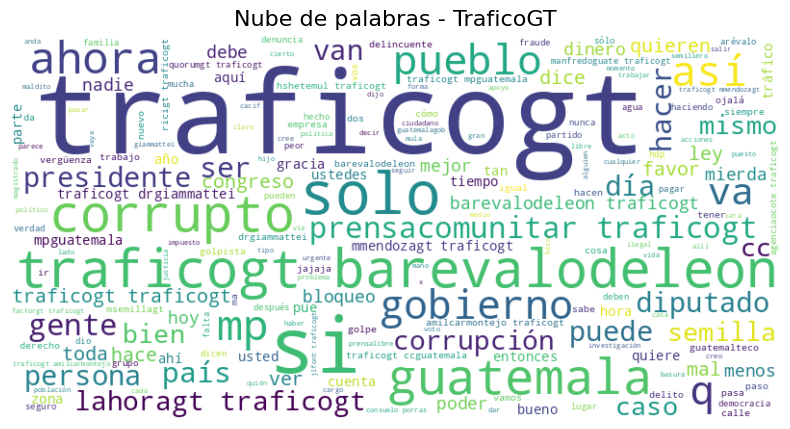

In [21]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def analisis_basico(df, nombre="dataset"):
    print(f" Análisis básico de {nombre}")
    print("Tweets totales:", len(df))
    print("Usuarios únicos:", df['user'].nunique())
    
    
    total_menciones = sum(len(m) for m in df['mentions'])
    print("Total de menciones:", total_menciones)
    
    
    total_respuestas = df['in_reply_to'].notna().sum()
    print("Total de respuestas:", total_respuestas)
    
    
    total_retweets = df['retweets'].sum()
    print("Total de retweets:", total_retweets)
    
    
    top_users = df['user'].value_counts().head(5)
    print("\n Usuarios más activos:")
    print(top_users)
    
    
    todas_menciones = [m for sublist in df['mentions'] for m in sublist]
    top_menciones = Counter(todas_menciones).most_common(5)
    print("\n Menciones más frecuentes:")
    print(top_menciones)


analisis_basico(df_trafico, "TraficoGT")


def nube_palabras(df, nombre="dataset"):
    texto = " ".join(df["texto_limpio"].dropna())
    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nube de palabras - {nombre}", fontsize=16)
    plt.show()


nube_palabras(df_trafico, "TraficoGT")


 Análisis básico de TioBerny
Tweets totales: 5019
Usuarios únicos: 2620
Total de menciones: 17310
Total de respuestas: 4370
Total de retweets: 109290

 Usuarios más activos:
user
ElrevoltijoGT      40
BenitoC67601310    31
ialmgg             21
arronchopa         21
MinfinGT           20
Name: count, dtype: int64

 Menciones más frecuentes:
[('BArevalodeLeon', 4830), ('GuatemalaGob', 915), ('UbaldoMacu', 574), ('santipalomov', 528), ('MPguatemala', 466)]


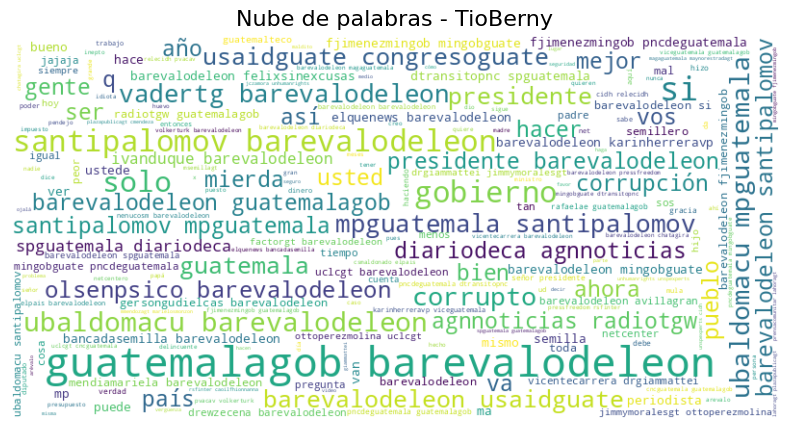

In [22]:
analisis_basico(df_tioberny, "TioBerny")
nube_palabras(df_tioberny, "TioBerny")


### **Preguntas del analisis**

- ¿Qué cuentas concentran más menciones en cada dataset y qué implica esto?
En el caso de TraficoGT, la cuenta más mencionada fue la propia @traficogt con 4,243 menciones, seguida por @BArevalodeLeon con 432. Esto refleja que la conversación gira principalmente alrededor del perfil informativo de tráfico, con un segundo eje en la política nacional. En contraste, en TioBerny la cuenta más mencionada fue @BArevalodeLeon con 4,830 menciones, seguida de @GuatemalaGob con 915. Este patrón muestra que la dinámica de interacción en TioBerny está más centrada en figuras políticas y gubernamentales, lo cual refuerza su orientación hacia la crítica y el debate político

- ¿Cuál dataset muestra mayor nivel de interacción en términos de retweets y respuestas?
Los resultados indican que TraficoGT acumuló 168,891 retweets y 4,150 respuestas, mientras que TioBerny registró 109,290 retweets y 4,370 respuestas. Esto sugiere dinámicas diferentes: TraficoGT funciona más como un canal de difusión masiva de información —los usuarios tienden a compartirlo más—, mientras que TioBerny genera una mayor cantidad de respuestas directas, lo que lo convierte en un espacio de conversación y confrontación de opiniones políticas.

- ¿Qué temas predominan en el lenguaje de los tweets de cada dataset?
En la nube de palabras de TraficoGT destacan términos como “traficogt”, “barevalodeleon”, “corrupción”, “gobierno” y “guatemala”, lo que indica que se entremezclan tanto temas de tráfico ciudadano como discusiones sobre la política nacional. En cambio, la nube de TioBerny presenta un sesgo mucho más político, con palabras como “barevalodeleon”, “guatemalagob”, “santipalomov”, “corrupción” y “presidente”. Este contraste revela que mientras TraficoGT mantiene un carácter híbrido entre lo informativo y lo político, TioBerny se enfoca principalmente en la crítica política y gubernamental.

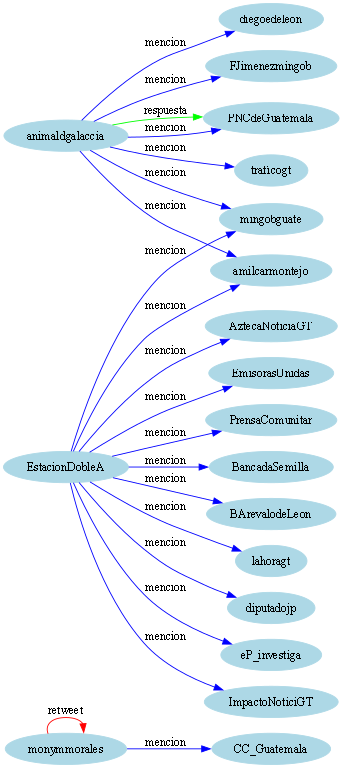

In [23]:
import pandas as pd
from graphviz import Digraph
from IPython.display import Image

# --- Construir red de interacciones ---
def construir_red(df):
    edges = []
    for _, row in df.iterrows():
        origen = row["user"]

        # Menciones
        for m in row["mentions"]:
            edges.append({"source": origen, "target": m, "tipo": "mencion"})

        # Respuestas
        if row["in_reply_to"]:
            edges.append({"source": origen, "target": row["in_reply_to"], "tipo": "respuesta"})

        # Retweets
        if row["retweets"] > 0:
            edges.append({"source": origen, "target": row["user"], "tipo": "retweet"})
    
    return pd.DataFrame(edges)

# --- Graficar con Graphviz ---
def graficar_red(df_red, titulo="subred"):
    dot = Digraph(comment=titulo)
    dot.attr(rankdir="LR", size="8")
    
    # Nodos
    usuarios = set(df_red["source"]).union(set(df_red["target"]))
    for u in usuarios:
        dot.node(u, u, shape="ellipse", color="lightblue", style="filled")
    
    # Aristas
    for _, row in df_red.iterrows():
        color = "black"
        if row["tipo"] == "mencion":
            color = "blue"
        elif row["tipo"] == "respuesta":
            color = "green"
        elif row["tipo"] == "retweet":
            color = "red"
        
        dot.edge(row["source"], row["target"], label=row["tipo"], color=color)
    
    return dot

# ================================
# EJEMPLO DE USO PARA AMBOS DF
# ================================

# Construir redes
red_trafico = construir_red(df_trafico)
red_tioberny = construir_red(df_tioberny)

# --- Subred con los primeros 20 registros ---
sub_red_trafico = red_trafico.head(20)
sub_red_tioberny = red_tioberny.head(20)

# --- Graficar y mostrar inline ---
dot_trafico = graficar_red(sub_red_trafico, "Subred TraficoGT")
dot_tioberny = graficar_red(sub_red_tioberny, "Subred TioBerny")

Image(dot_trafico.pipe(format="png"))
